# Autonomous decomposition

Based on Girardi and Pariboni (2015), Freitas and Dweck (2013) and Leamer (2007)

# Loading libraries

In [0]:
import datetime
t1 = datetime.datetime.now()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Defining start and end dates

In [0]:
start = datetime.datetime(1949,1,1)
end = datetime.datetime(2017,1,1)

Function to plot recessions bars:

In [0]:
recessions = web.get_data_fred('USRECM', start, end)
recessions.columns = ['Recessions']
recessions['xmin'] = False
recessions['xmax'] = False
for i in range(len(recessions['Recessions'])-1):
  recessions.iscopy = True
  if recessions['Recessions'].iloc[i] == 0 and recessions['Recessions'].iloc[i+1] == 1:
      recessions['xmin'].iloc[i+1] = True
  elif recessions['Recessions'].iloc[i] == 1 and recessions['Recessions'].iloc[i+1] == 0:
      recessions['xmax'].iloc[i+1] = True
recessions.head()

def recessions_bars():
    import matplotlib.pyplot as plt
    xmin = recessions[recessions['xmin'] == True]['xmin']
    xmax = recessions[recessions['xmax'] == True]['xmax']
    
    for i in range(len(xmax)):
        ax.axvspan(xmin = xmin.index[i], xmax = xmax.index[i], alpha=.3, color='k')
        
print(recessions['xmin'][recessions['xmin'] == True].index)
recessions['xmax'][recessions['xmax'] == True]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


DatetimeIndex(['1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01',
               '1973-11-01', '1980-01-01', '1981-07-01', '1990-07-01',
               '2001-03-01', '2007-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)


DATE
1949-11-01    True
1954-06-01    True
1958-05-01    True
1961-03-01    True
1970-12-01    True
1975-04-01    True
1980-08-01    True
1982-12-01    True
1991-04-01    True
2001-12-01    True
2009-07-01    True
Name: xmax, dtype: bool

Defining plot default style:

In [0]:
plt.style.use('bmh')

def default_plot():
  plt.xlabel('')
  sns.set_context('talk')
  plt.rcParams['axes.edgecolor']='#333F4B'
  plt.rcParams['axes.linewidth']=0.8
  plt.rcParams['xtick.color']='#333F4B'
  plt.rcParams['ytick.color']='#333F4B'
  ax.grid(False)
  # change the style of the axis spines
  ax.spines['top'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.spines['left'].set_smart_bounds(True)
  ax.spines['bottom'].set_smart_bounds(True)
  sns.despine()

%config InlineBackend.figure_format = 'retina'

# Getting data

In [0]:
df = web.get_data_fred(
    [
     'GDPC96',
     'EXPGSC96',
     'GCEC96',
     'A011RE1Q156NBEA',
     'HCCSDODNS', #'TOTALSL',
     'A008RE1Q156NBEA',
     'PCECC96',
     'IMPGS'
    ],
    start,
    end
)

df.columns = [
    'GDP',
    'Exports', 
    'Government spending',
    'Residential Investment',
    'Consumer credit',
    'Private non-residential investment',
    'Consumption',
    'Imports'
]

df = df.resample('QS').mean()

df['Residential Investment'] = df['Residential Investment']*df['GDP']/100
df['Private non-residential investment'] = df['Private non-residential investment']*df['GDP']/100


df.head()

,GDP,Exports,Government spending,Residential Investment,Consumer credit,Private non-residential investment,Consumption,Imports
DATE,,,,,,,,
1949-01-01,2007.522,72.337,548.580,104.391144,NaN,208.782288,1337.177,9.604
1949-04-01,2000.788,71.718,572.489,102.040188,NaN,202.079588,1357.672,9.364
1949-07-01,2022.798,65.727,577.631,109.231092,NaN,194.188608,1360.751,8.936
1949-10-01,2004.653,56.898,565.759,122.283833,19.374,190.442035,1380.702,9.092
1950-01-01,2084.559,55.960,557.123,135.496335,NaN,195.948546,1403.690,9.501


In [0]:
#!wget 'https://www.sipri.org/sites/default/files/SIPRI-Milex-data-1949-2017.xlsx'
#!mv 'SIPRI-Milex-data-1949-2017.xlsx' 'milex.xlsx'
#
#milex = pd.read_excel('milex.xlsx', sheet_name = "Constant (2016) USD", skiprows = 5)
#milex = milex.drop(['Unnamed: 1', 'Notes', '2017 Current', 'Unnamed: 73', 'Unnamed: 74', 'Unnamed: 75'], axis = 1)
#milex = milex[milex['Country'] == 'USA']
#milex = milex.drop('Country', axis = 1)
#milex = milex.transpose()
#milex.columns = ['Military Expenditures']
#milex.index = df.index
#milex['Military Expenditures'] = pd.to_numeric(milex['Military Expenditures'])
#milex.head()

Defining autonomous expenditures (Z):

In [0]:
Z = [
    'Exports',
    'Government spending',
    'Residential Investment',
    'Consumer credit'
]


df['Autonomous'] = df[Z].sum(axis = 1)

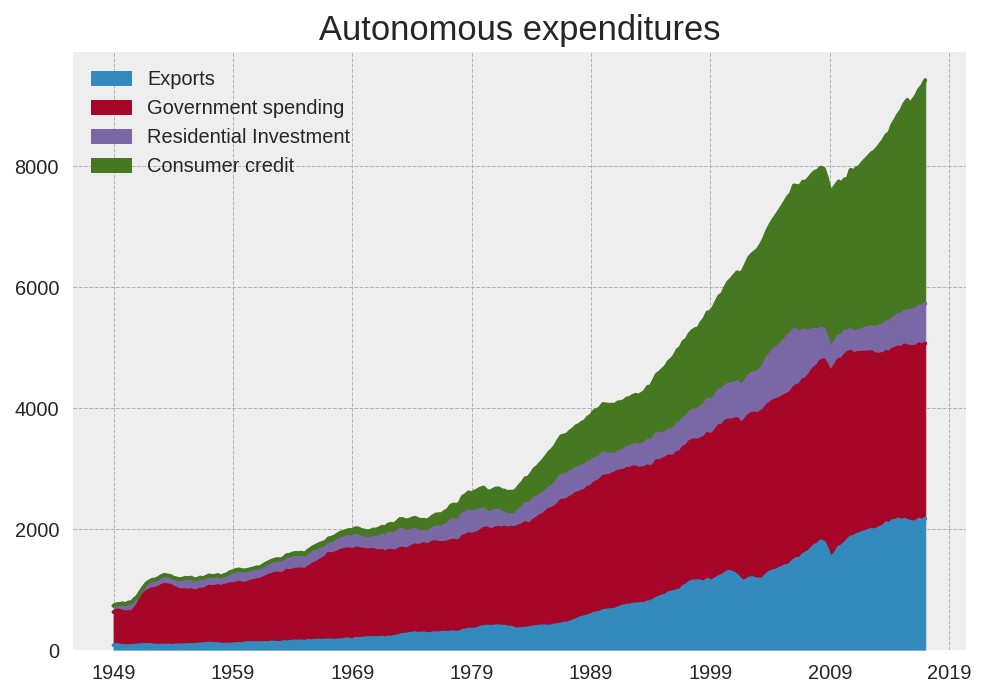

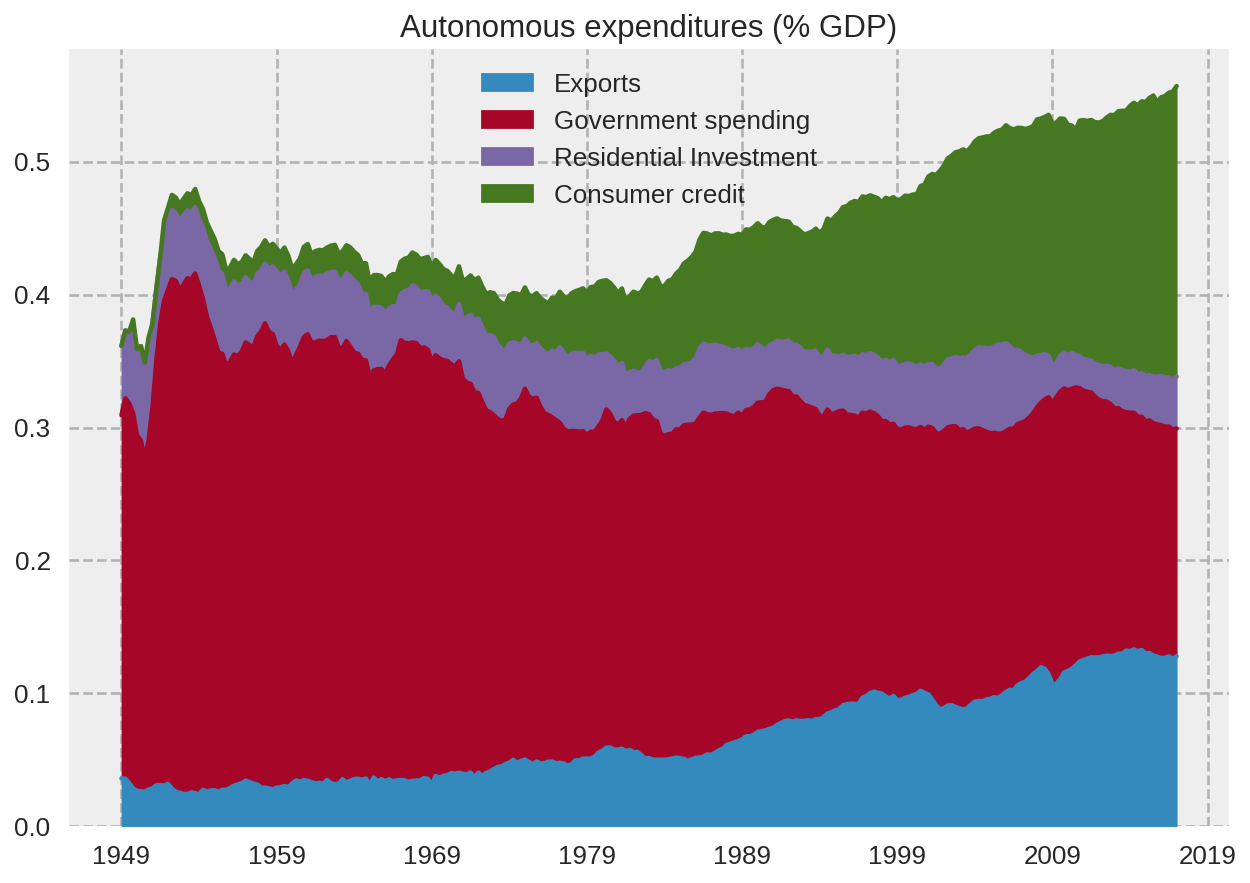

In [0]:
ax = df[Z].plot(kind='area', stacked=True)
plt.title('Autonomous expenditures')
sns.despine()
sns.set_context('talk')
plt.xlabel('')
plt.show()

ax = df[Z].apply(lambda x: x/df['GDP']).plot(kind='area')
plt.title('Autonomous expenditures (% GDP)')
sns.despine()
sns.set_context('talk')
plt.xlabel('')
plt.show()

Defining supermultiplier components:

$$
m = \frac{M}{Y}
$$


$$
h = \frac{I}{Y}
$$


$$
s = 1 - \frac{C}{Y}
$$

$$
SSM = \frac{1}{m + s - h}
$$

In [0]:
df['m'] = df['Imports']/df['GDP']
df['h'] = df['Private non-residential investment']/df['GDP']
df['s'] = 1 - (df['Consumption'] - df['Consumer credit'] - df['Residential Investment'])/df['GDP']

df['SSM'] = 1/(df['m'] + df['s'] - df['h'])

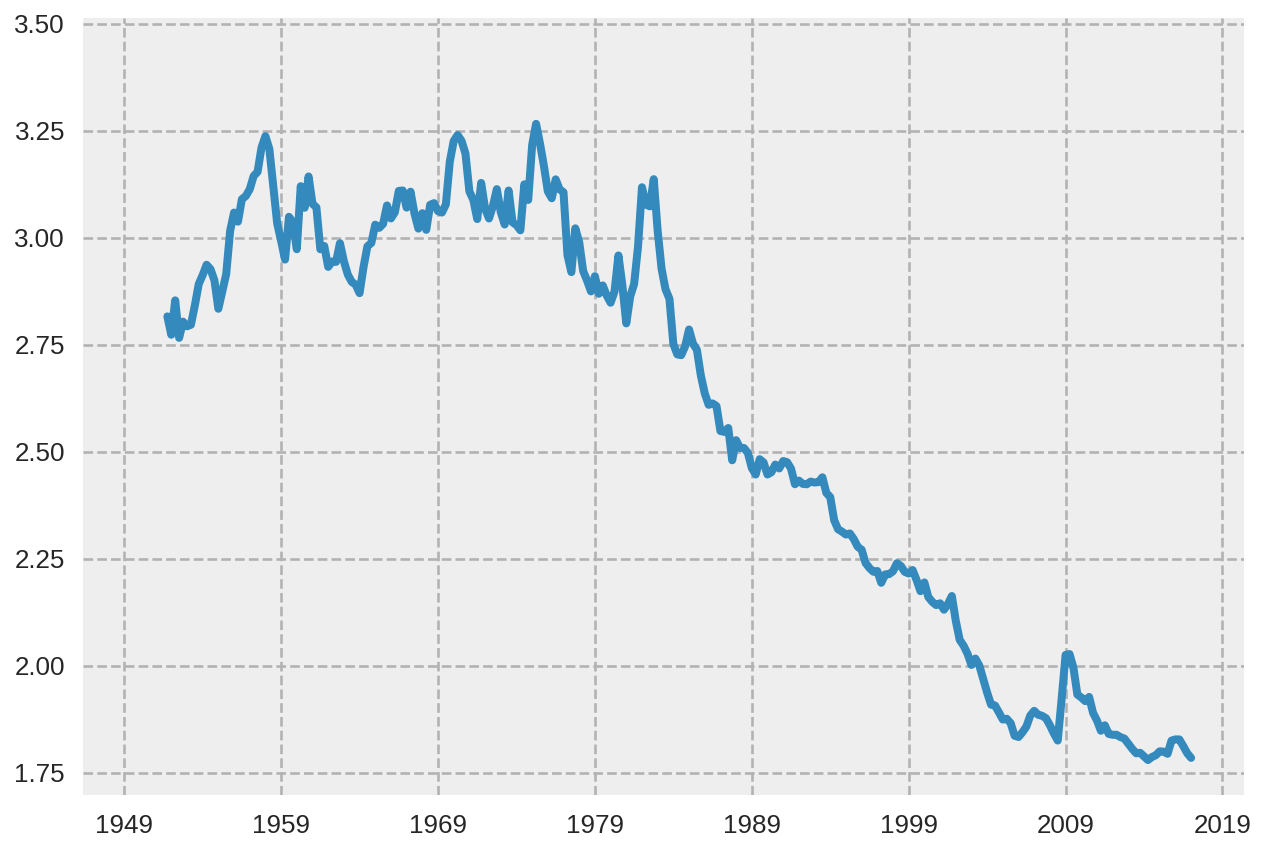

In [0]:
ax = df['SSM'].plot(lw=4)
sns.despine()
sns.set_context('talk')
plt.xlabel('')
plt.show()

In [0]:
df['GDP (SSM)'] = df['Autonomous']*df['SSM']

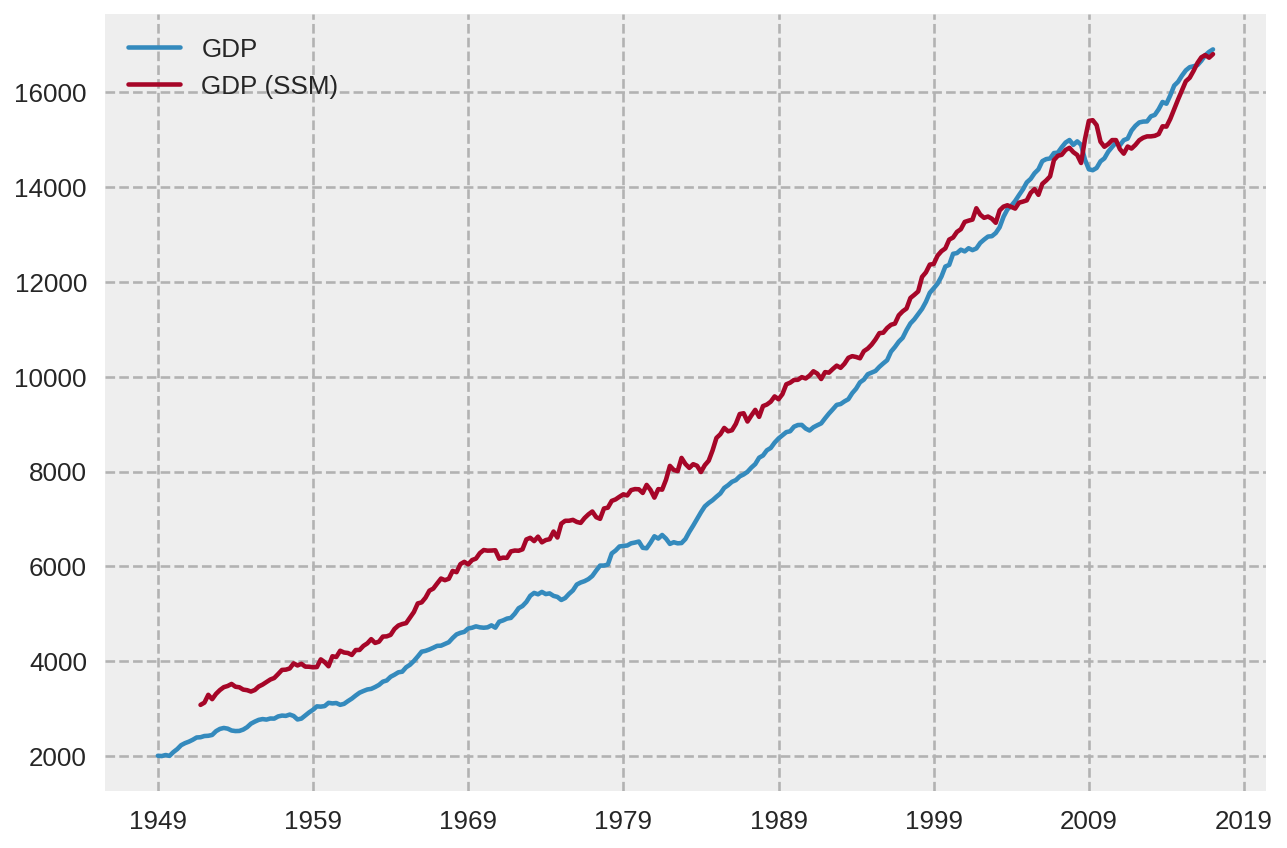

In [0]:
ax = df[['GDP','GDP (SSM)']].plot()
sns.despine()
sns.set_context('talk')
plt.xlabel('')
plt.show()

Relation between autonomous expenditures and Investment share:

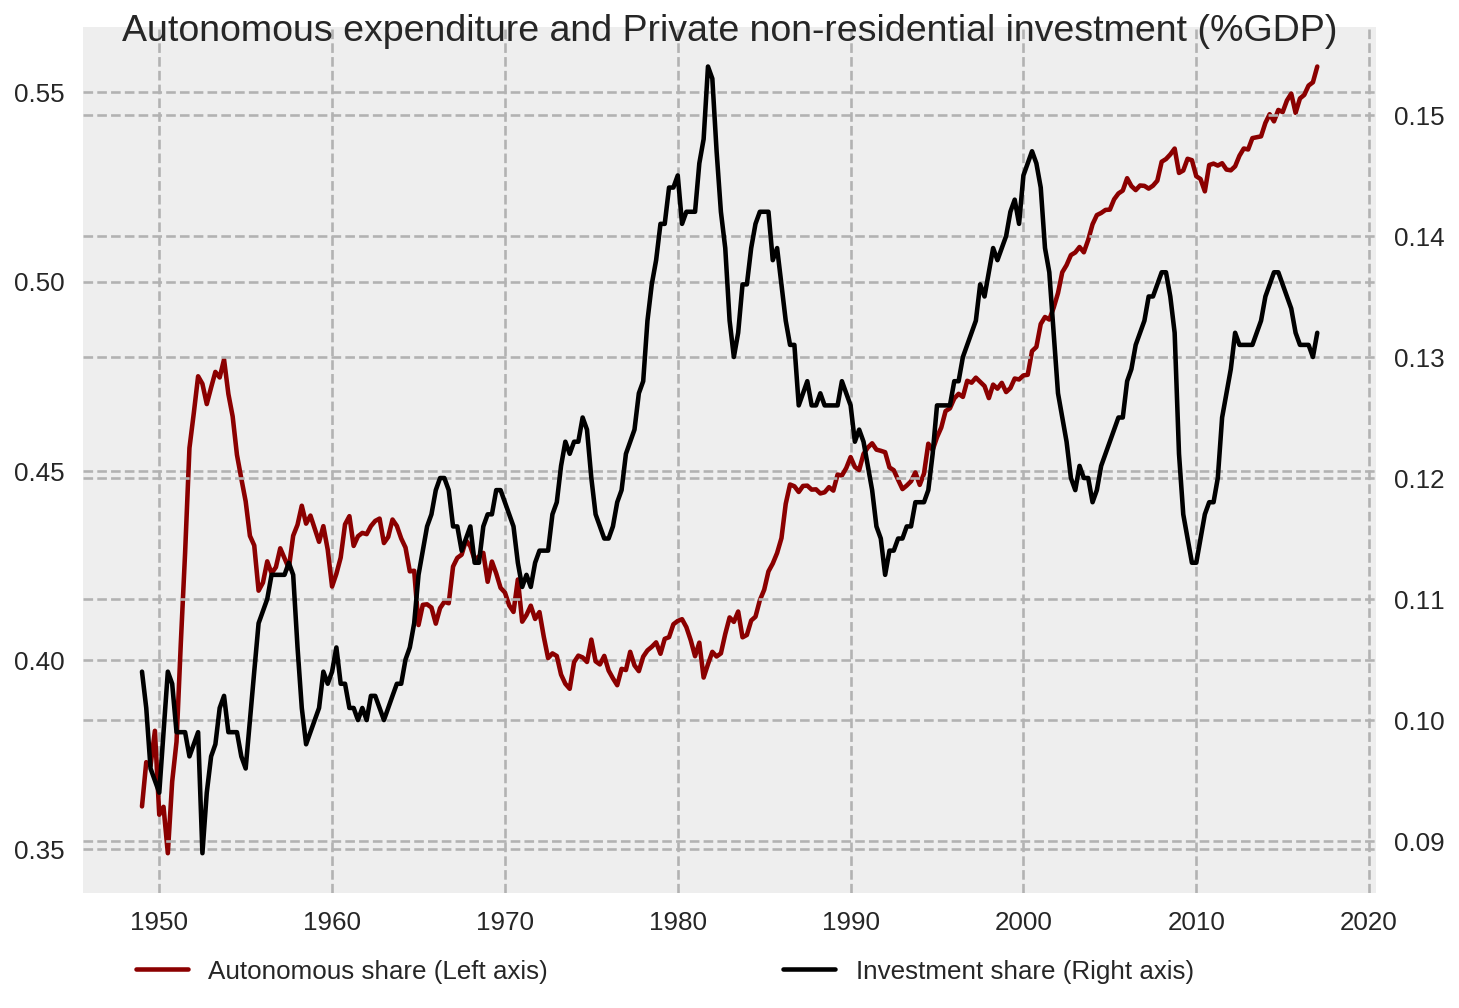

In [0]:
fig, ax1 = plt.subplots()
fig.suptitle('Autonomous expenditure and Private non-residential investment (%GDP)')
ax1.plot(df['Autonomous']/df['GDP'], color='darkred', label='Autonomous share (Left axis)')
plt.legend(loc='upper center', bbox_to_anchor=(0.2, -0.05))
ax2 = ax1.twinx()
ax2.plot(df['Private non-residential investment']/df['GDP'], color='k', label='Investment share (Right axis)')
sns.despine(right=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.7, -0.05))
fig.tight_layout()
plt.show()

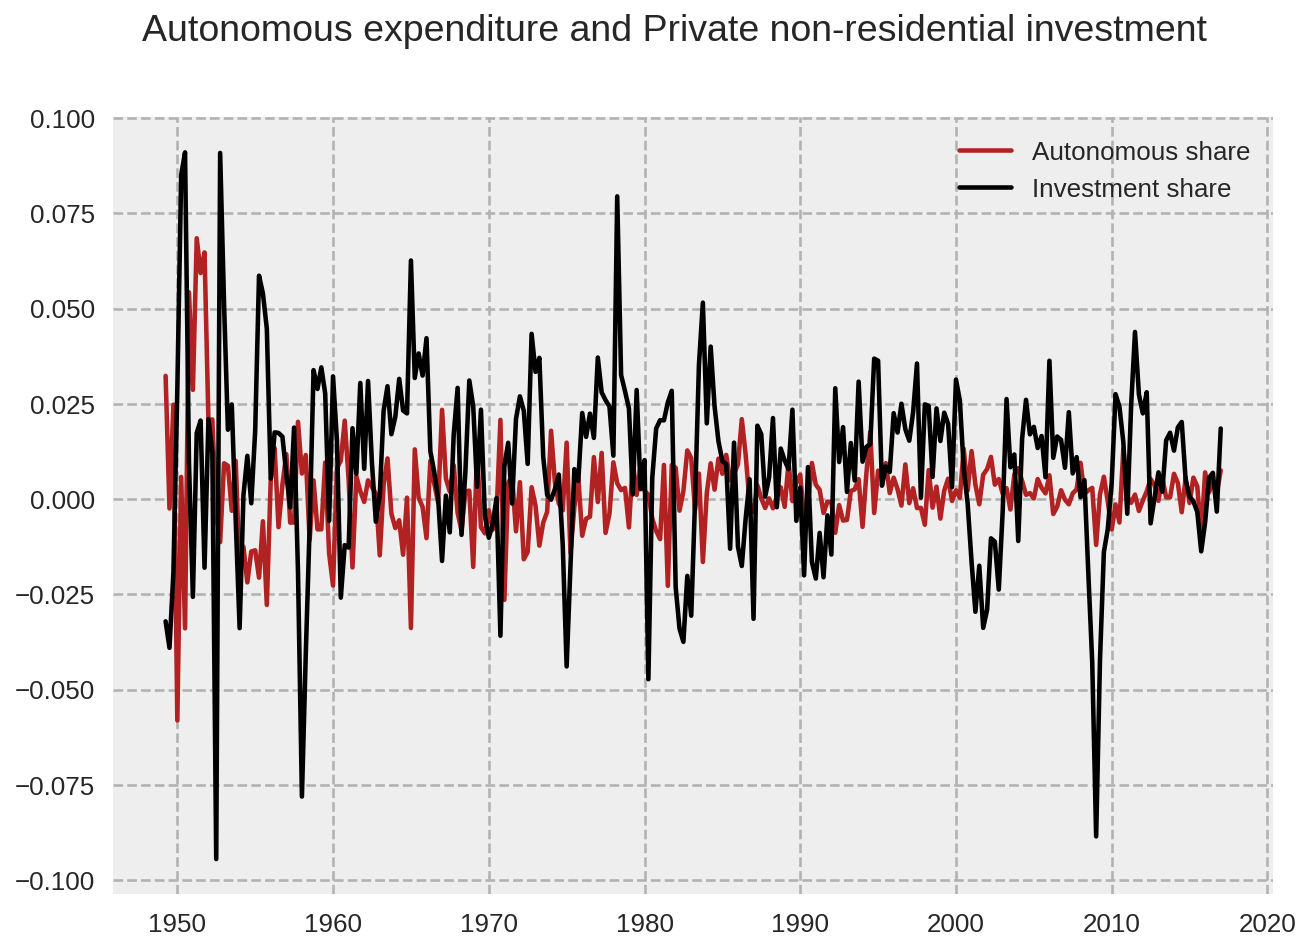

In [0]:
fig, ax = plt.subplots()
fig.suptitle('Autonomous expenditure and Private non-residential investment')
#ax.set_title('Seasonlly adjusted growth rate as %GDP')
ax.plot((df['Autonomous']/df['GDP']).pct_change(), color='firebrick', label='Autonomous share')
ax.plot((df['Private non-residential investment']).pct_change(), color='k', label='Investment share')
sns.despine()
plt.legend()
plt.show()
#fig.savefig('Autonomous_Invetment_grw.png', transparent=True, dpi=300)

# Peak centered plot

In [0]:
x = [int(i) for i in range(9)]
xaxis = np.linspace(-4,4,9, dtype = 'int')
peak = recessions['xmin'][recessions['xmin'] == True].index
centered = [[(peak[i] - pd.to_timedelta(12, unit='M')).strftime('%Y-%m'), peak[i].strftime('%Y-%m'),(peak[i] + pd.to_timedelta(12, unit='M')).strftime('%Y-%m')] for i in range(len(peak))]
centered = centered[5:]

trough = recessions['xmax'][recessions['xmax'] == True].index
centeredT = [[(trough[i] - pd.to_timedelta(12, unit='M')).strftime('%Y-%m'), trough[i].strftime('%Y-%m'),(trough[i] + pd.to_timedelta(12, unit='M')).strftime('%Y-%m')] for i in range(len(trough))]
centeredT = centeredT[6:]

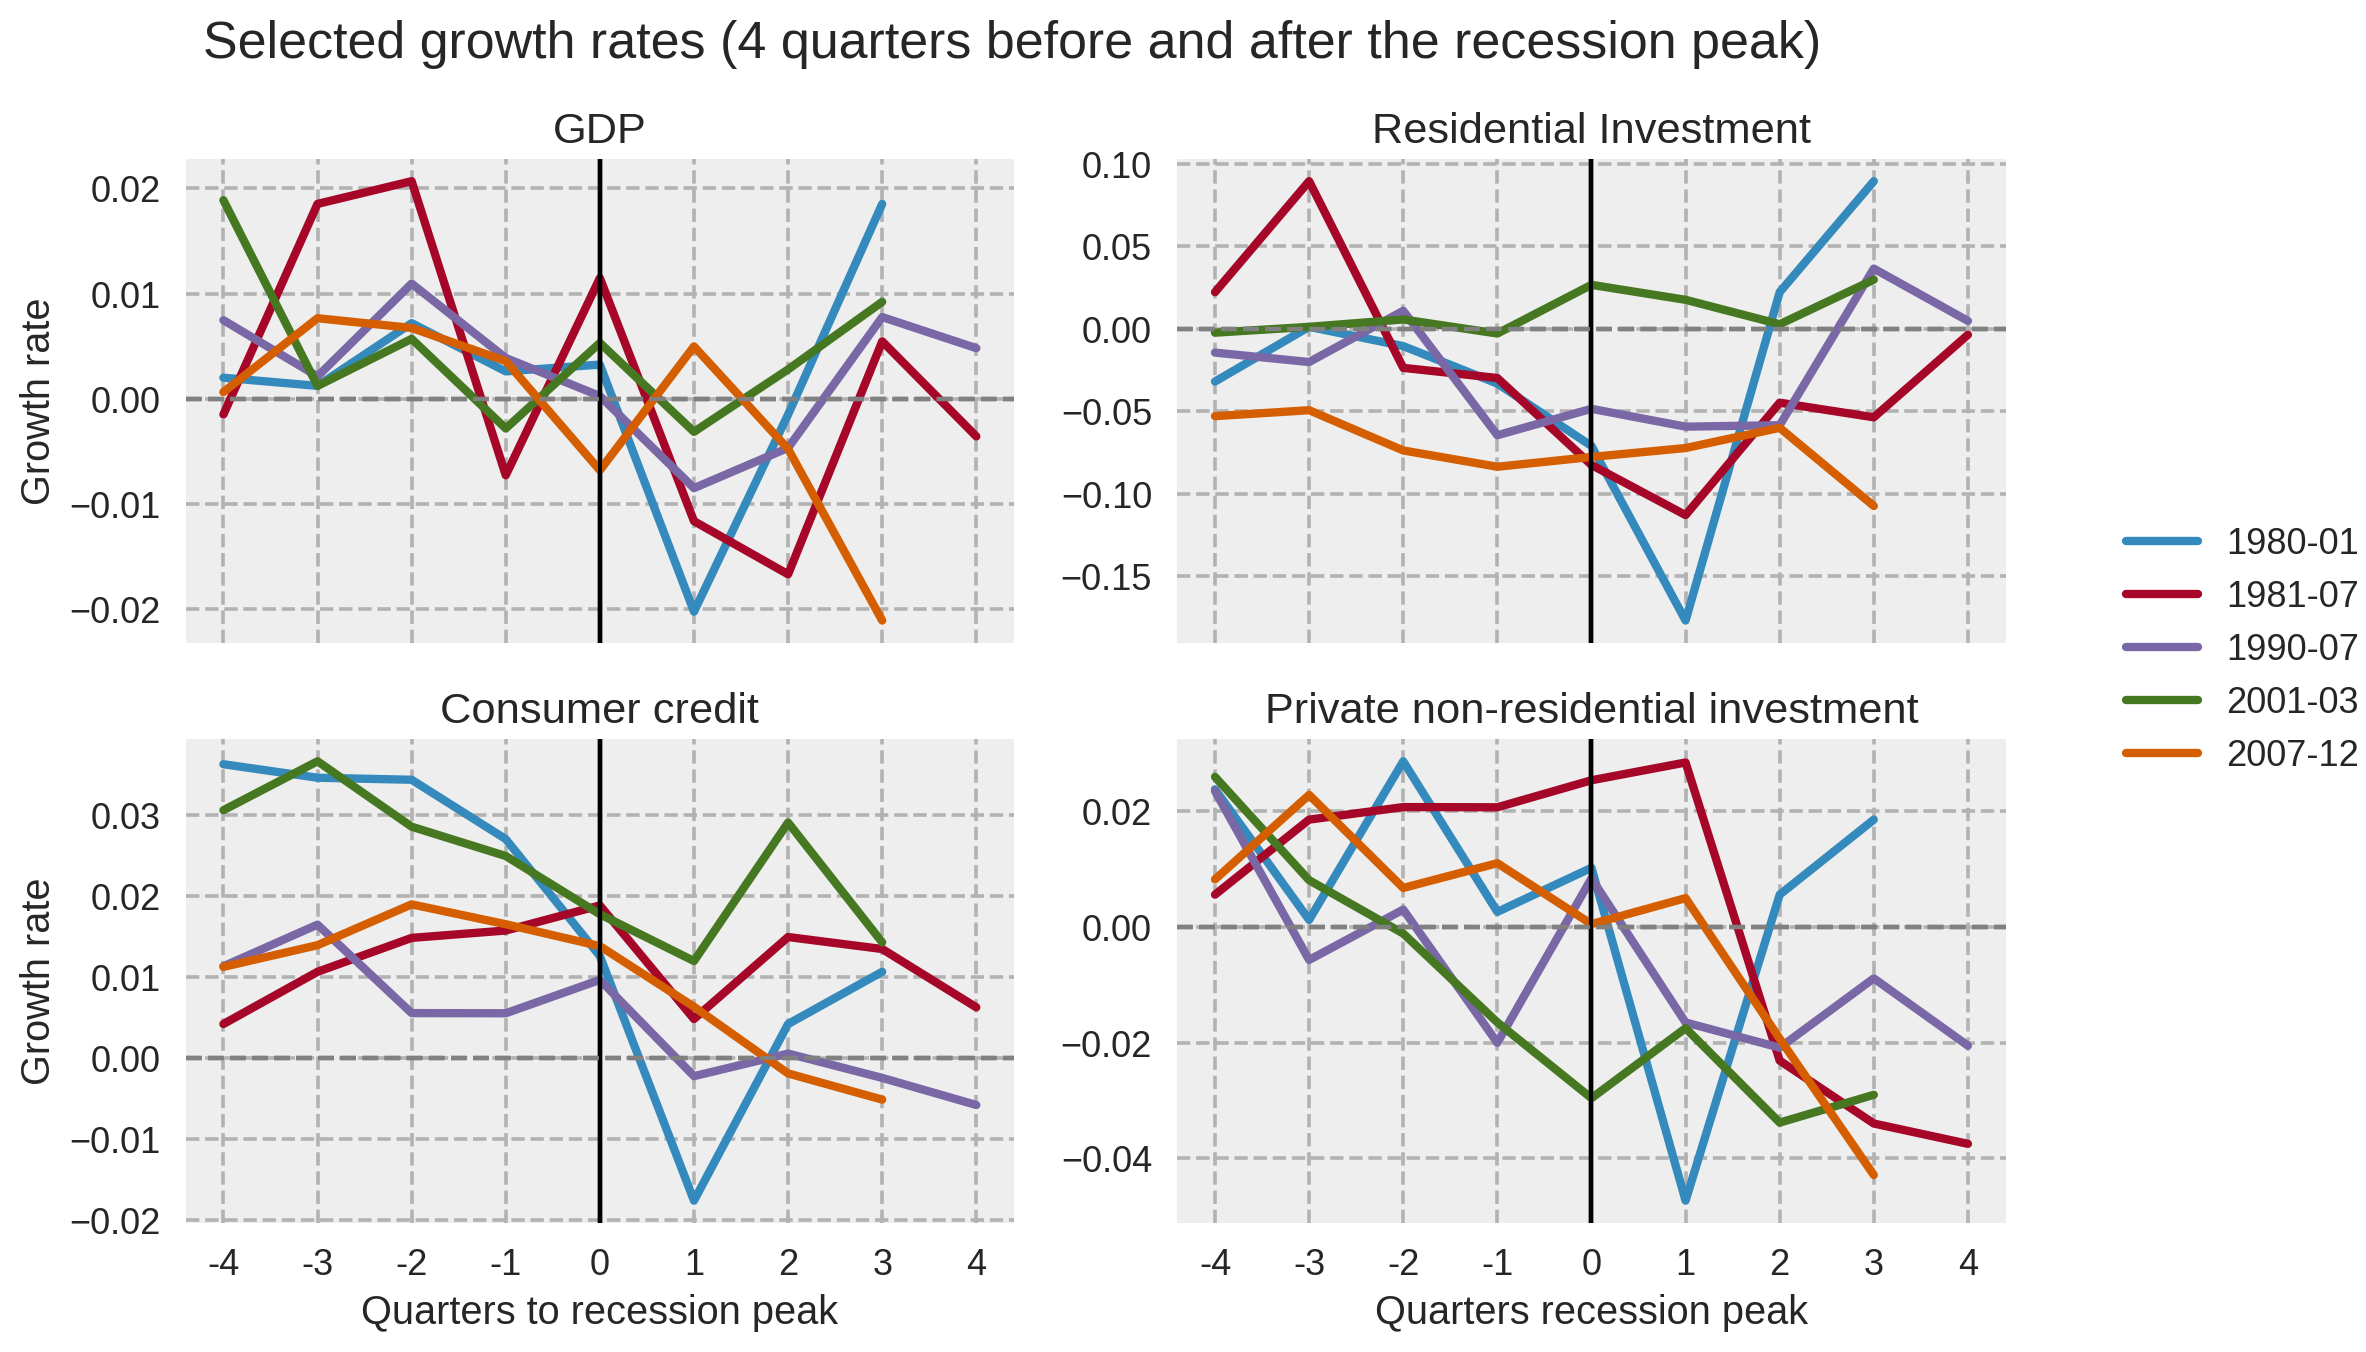

In [0]:
fig, ax = plt.subplots(2,2, sharex=True)

for i in range(len(centered)):
  ax[0,0].plot(df['GDP'].pct_change()[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=3, ls='-')
  handles, labels = ax[0,0].get_legend_handles_labels()
  ax[0,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,0].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[0,0].set_title('GDP')
  ax[0,0].set_ylabel('Growth rate')

for i in range(len(centered)):
  ax[0,1].plot(df['Residential Investment'].pct_change()[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=3, ls='-')
  ax[0,1].set_title('Residential Investment')
  ax[0,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  


for i in range(len(centered)):
  ax[1,0].plot(df['Consumer credit'].pct_change()[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=3, ls='-')
  ax[1,0].set_title('Consumer credit')
  ax[1,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,0].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,0].set_xlabel('Quarters to recession peak')
  ax[1,0].set_ylabel('Private non-residential investment')
  ax[1,0].set_ylabel('Growth rate')

for i in range(len(centered)):
  ax[1,1].plot(df['Private non-residential investment'].pct_change()[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=3, ls='-')
  ax[1,1].set_title('Private non-residential investment')
  ax[1,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,1].set_xlabel('Quarters recession peak')
  
  

plt.xticks(x, xaxis)
sns.despine()
fig.legend(handles, labels, bbox_to_anchor=(1.15, 0.6))
fig.suptitle('Selected growth rates (4 quarters before and after the recession peak)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.set_dpi(100)
plt.show()

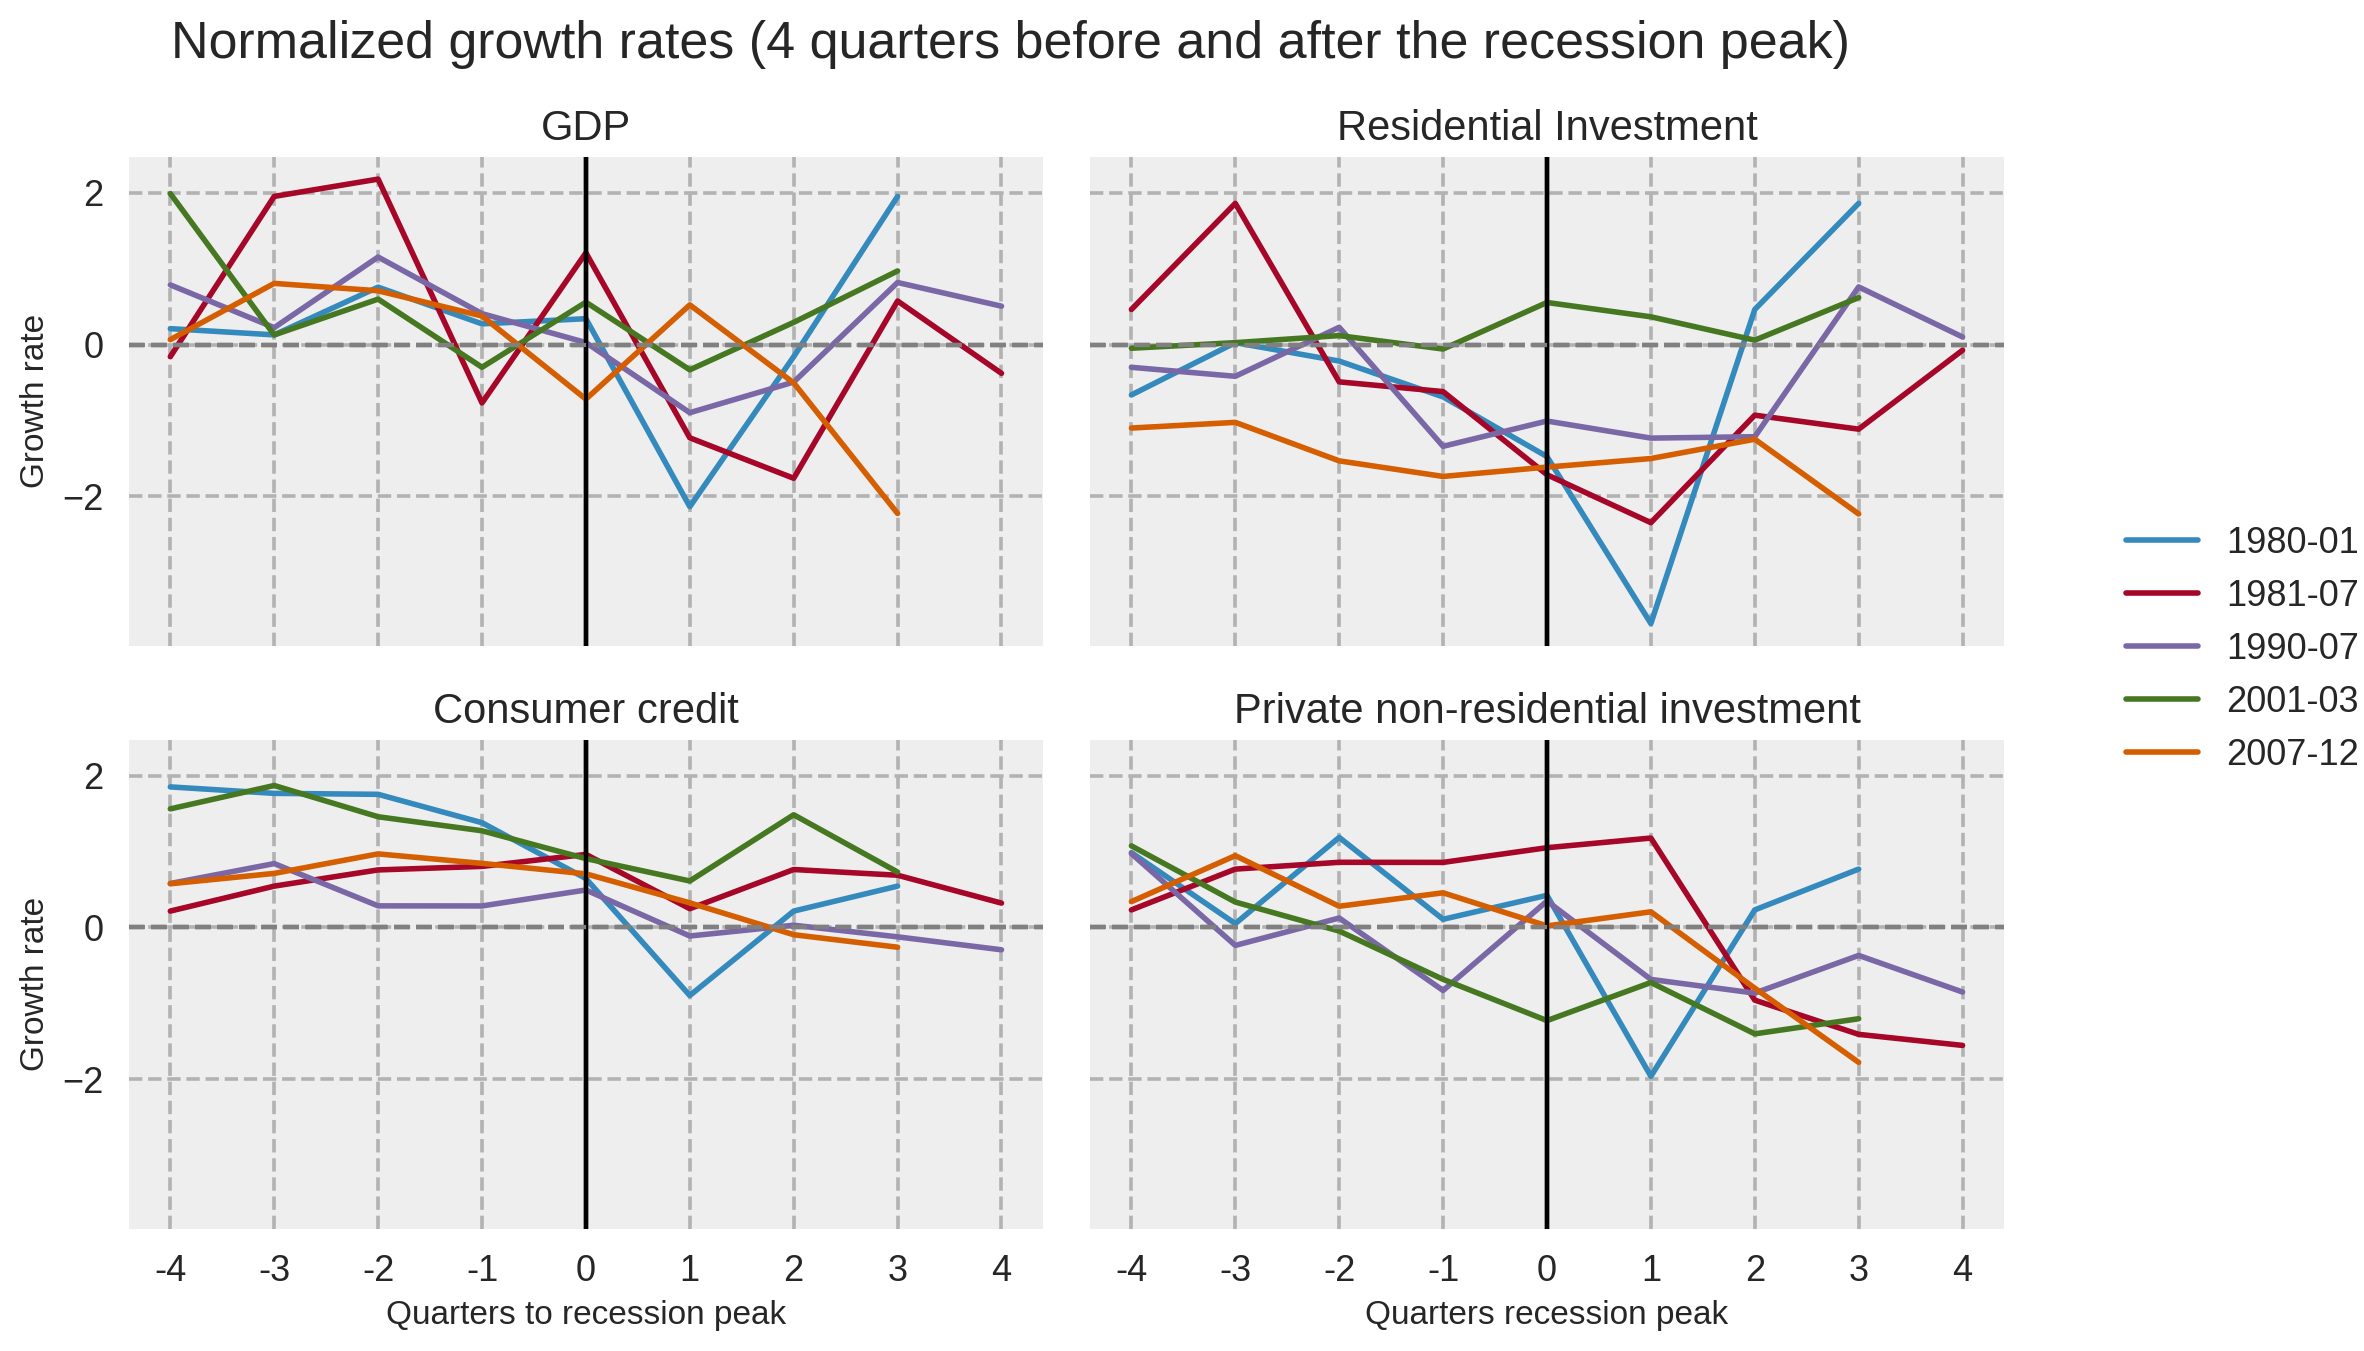

In [0]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)


for i in range(len(centered)):
  ax[0,0].plot(df['GDP'].pct_change().apply(lambda x: x/np.std(df['GDP'].pct_change()))[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=2, ls='-')
  handles, labels = ax[0,0].get_legend_handles_labels()
  ax[0,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,0].set_title('GDP', fontsize=15)
  ax[0,0].set_ylabel('Growth rate', fontsize=12)
  ax[0,0].axhline(y=0, color='gray', ls='--', lw=1.5)

for i in range(len(centered)):
  ax[0,1].plot(df['Residential Investment'].pct_change().apply(lambda x: x/np.std(df['Residential Investment'].pct_change()))[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=2, ls='-')
  ax[0,1].set_title('Residential Investment', fontsize=15)
  ax[0,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  


for i in range(len(centered)):
  ax[1,0].plot(df['Consumer credit'].pct_change().apply(lambda x: x/np.std(df['Consumer credit'].pct_change()))[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=2, ls='-')
  ax[1,0].set_title('Consumer credit', fontsize=15)
  ax[1,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,0].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,0].set_xlabel('Quarters to recession peak', fontsize=12)
  ax[1,0].set_ylabel('Private non-residential investment', fontsize=15)
  ax[1,0].set_ylabel('Growth rate', fontsize=12)

for i in range(len(centered)):
  ax[1,1].plot(df['Private non-residential investment'].pct_change().apply(lambda x: x/np.std(df['Private non-residential investment'].pct_change()))[centered[i][0]:centered[i][2]].values, label=centered[i][1], lw=2, ls='-')
  ax[1,1].set_title('Private non-residential investment', fontsize=15)
  ax[1,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,1].set_xlabel('Quarters recession peak', fontsize=12)
  
  

plt.xticks(x, xaxis)
sns.despine()
fig.legend(handles, labels, bbox_to_anchor=(1.15, 0.6))
fig.suptitle('Normalized growth rates (4 quarters before and after the recession peak)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.set_dpi(100)
plt.show()

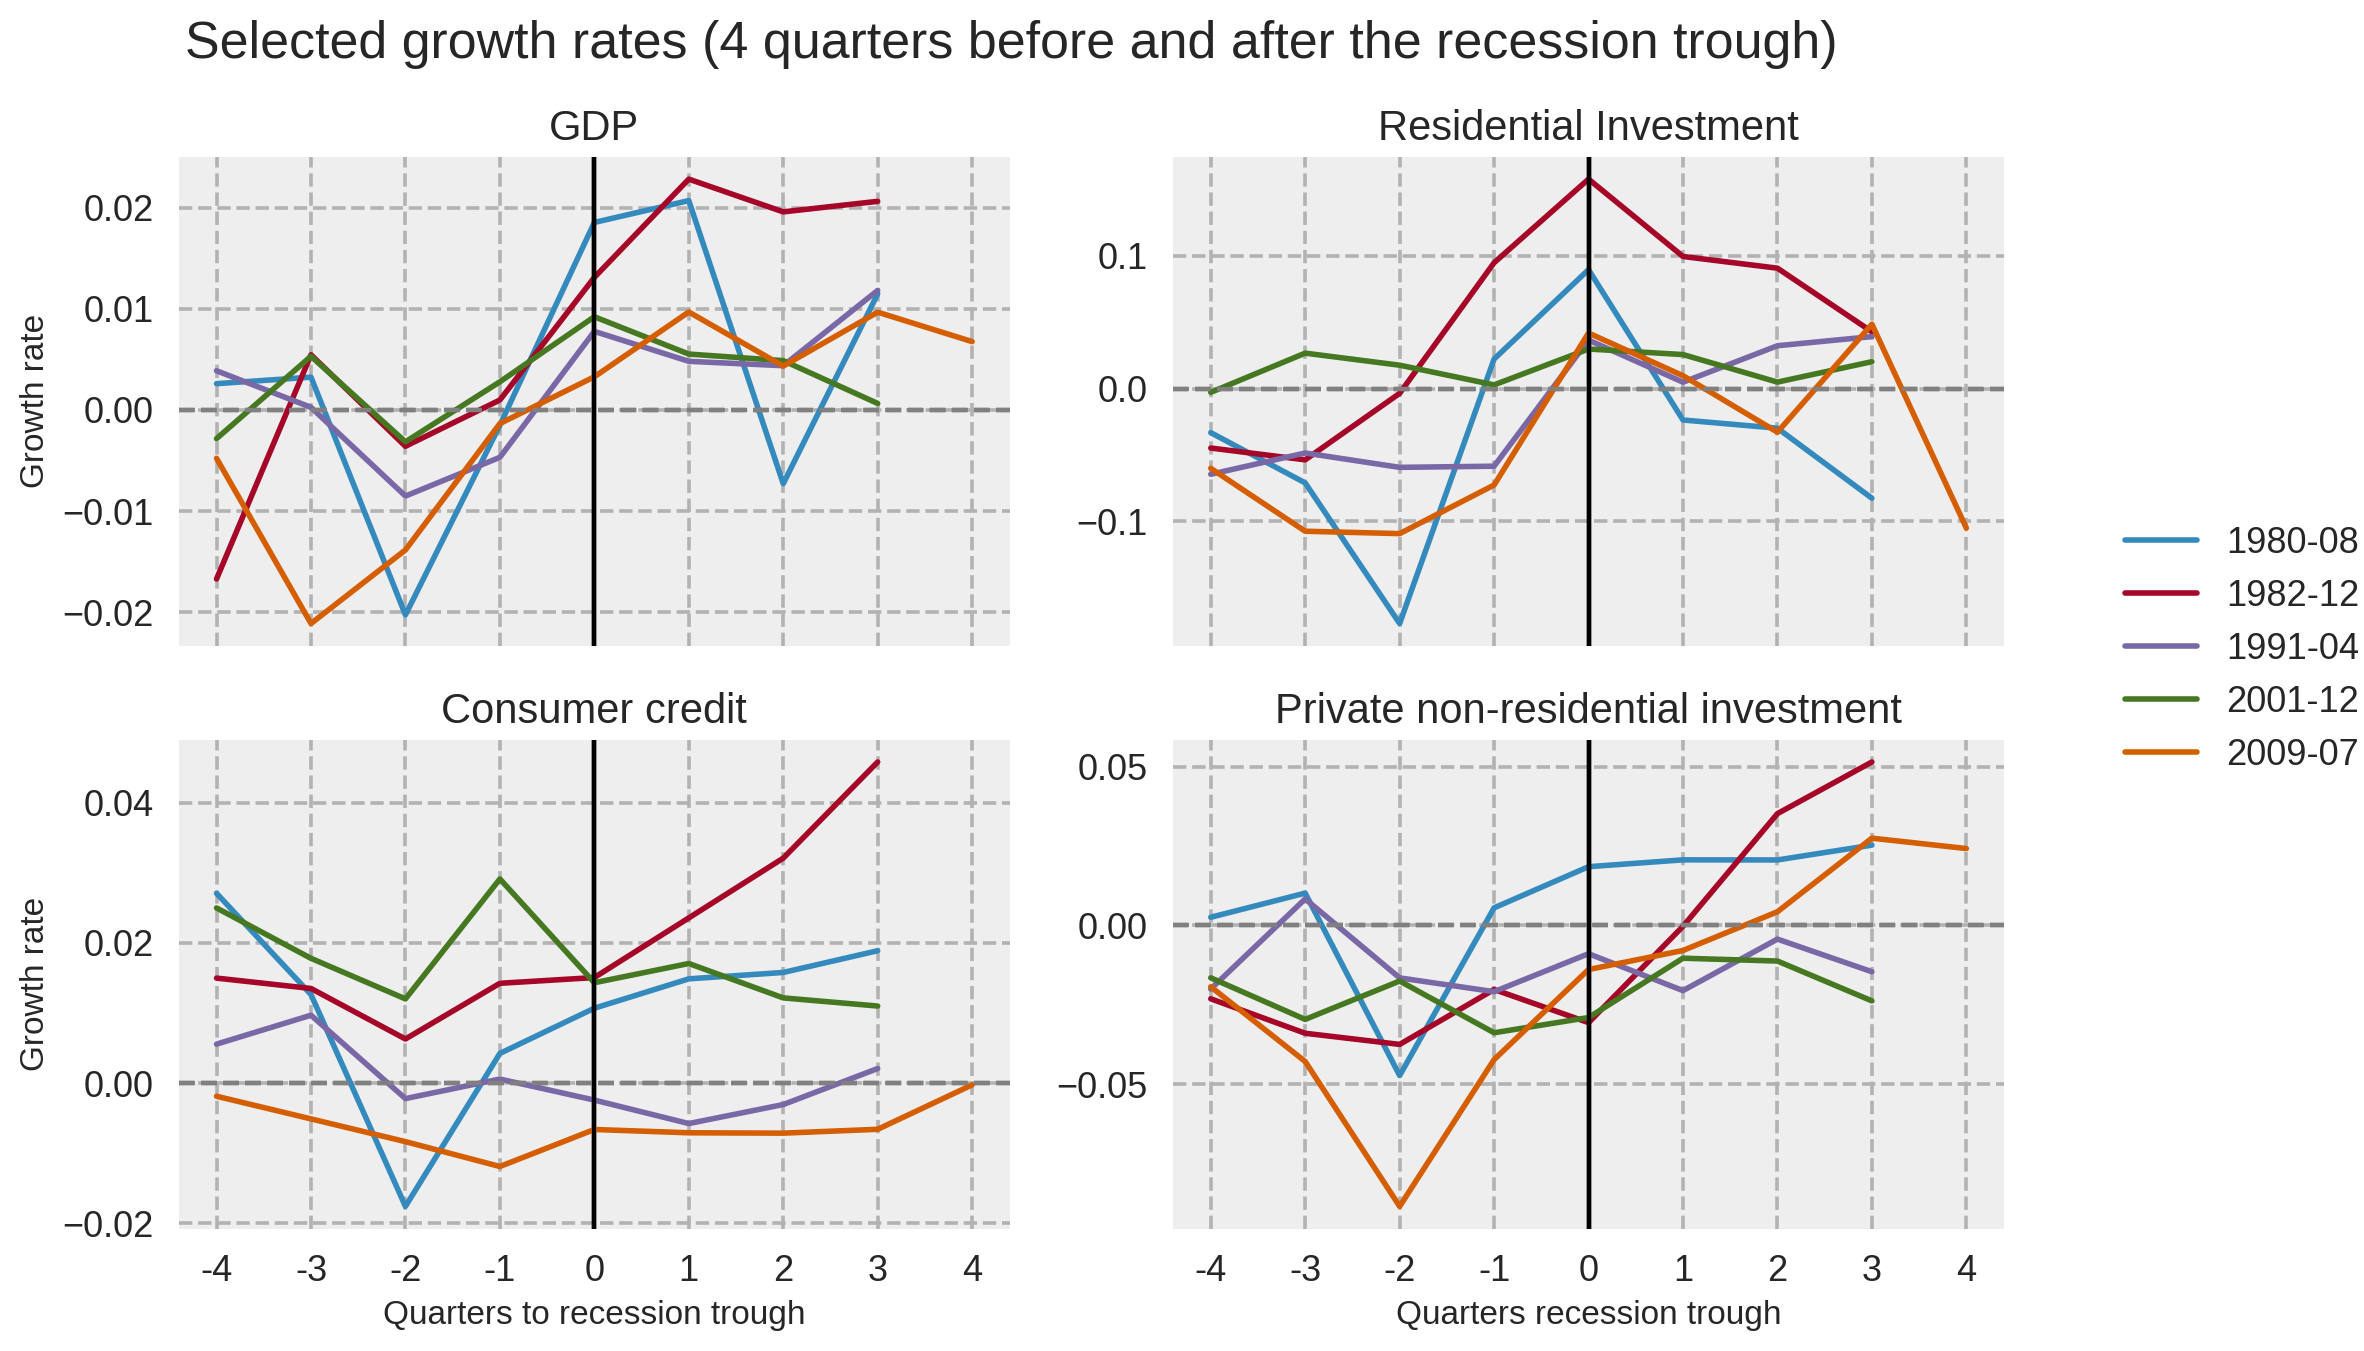

In [0]:
fig, ax = plt.subplots(2,2, sharex=True)

for i in range(len(centeredT)):
  ax[0,0].plot(df['GDP'].pct_change()[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  handles, labels = ax[0,0].get_legend_handles_labels()
  ax[0,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,0].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[0,0].set_title('GDP', fontsize=15)
  ax[0,0].set_ylabel('Growth rate', fontsize=12)

for i in range(len(centered)):
  ax[0,1].plot(df['Residential Investment'].pct_change()[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  ax[0,1].set_title('Residential Investment', fontsize=15)
  ax[0,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  


for i in range(len(centered)):
  ax[1,0].plot(df['Consumer credit'].pct_change()[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  ax[1,0].set_title('Consumer credit', fontsize=15)
  ax[1,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,0].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,0].set_xlabel('Quarters to recession trough', fontsize=12)
  ax[1,0].set_ylabel('Growth rate', fontsize=12)

for i in range(len(centered)):
  ax[1,1].plot(df['Private non-residential investment'].pct_change()[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  ax[1,1].set_title('Private non-residential investment', fontsize=15)
  ax[1,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,1].set_xlabel('Quarters recession trough', fontsize=12)
  
  

plt.xticks(x, xaxis)
sns.despine()
fig.legend(handles, labels, bbox_to_anchor=(1.15, 0.6))
fig.suptitle('Selected growth rates (4 quarters before and after the recession trough)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.set_dpi(100)
plt.show()

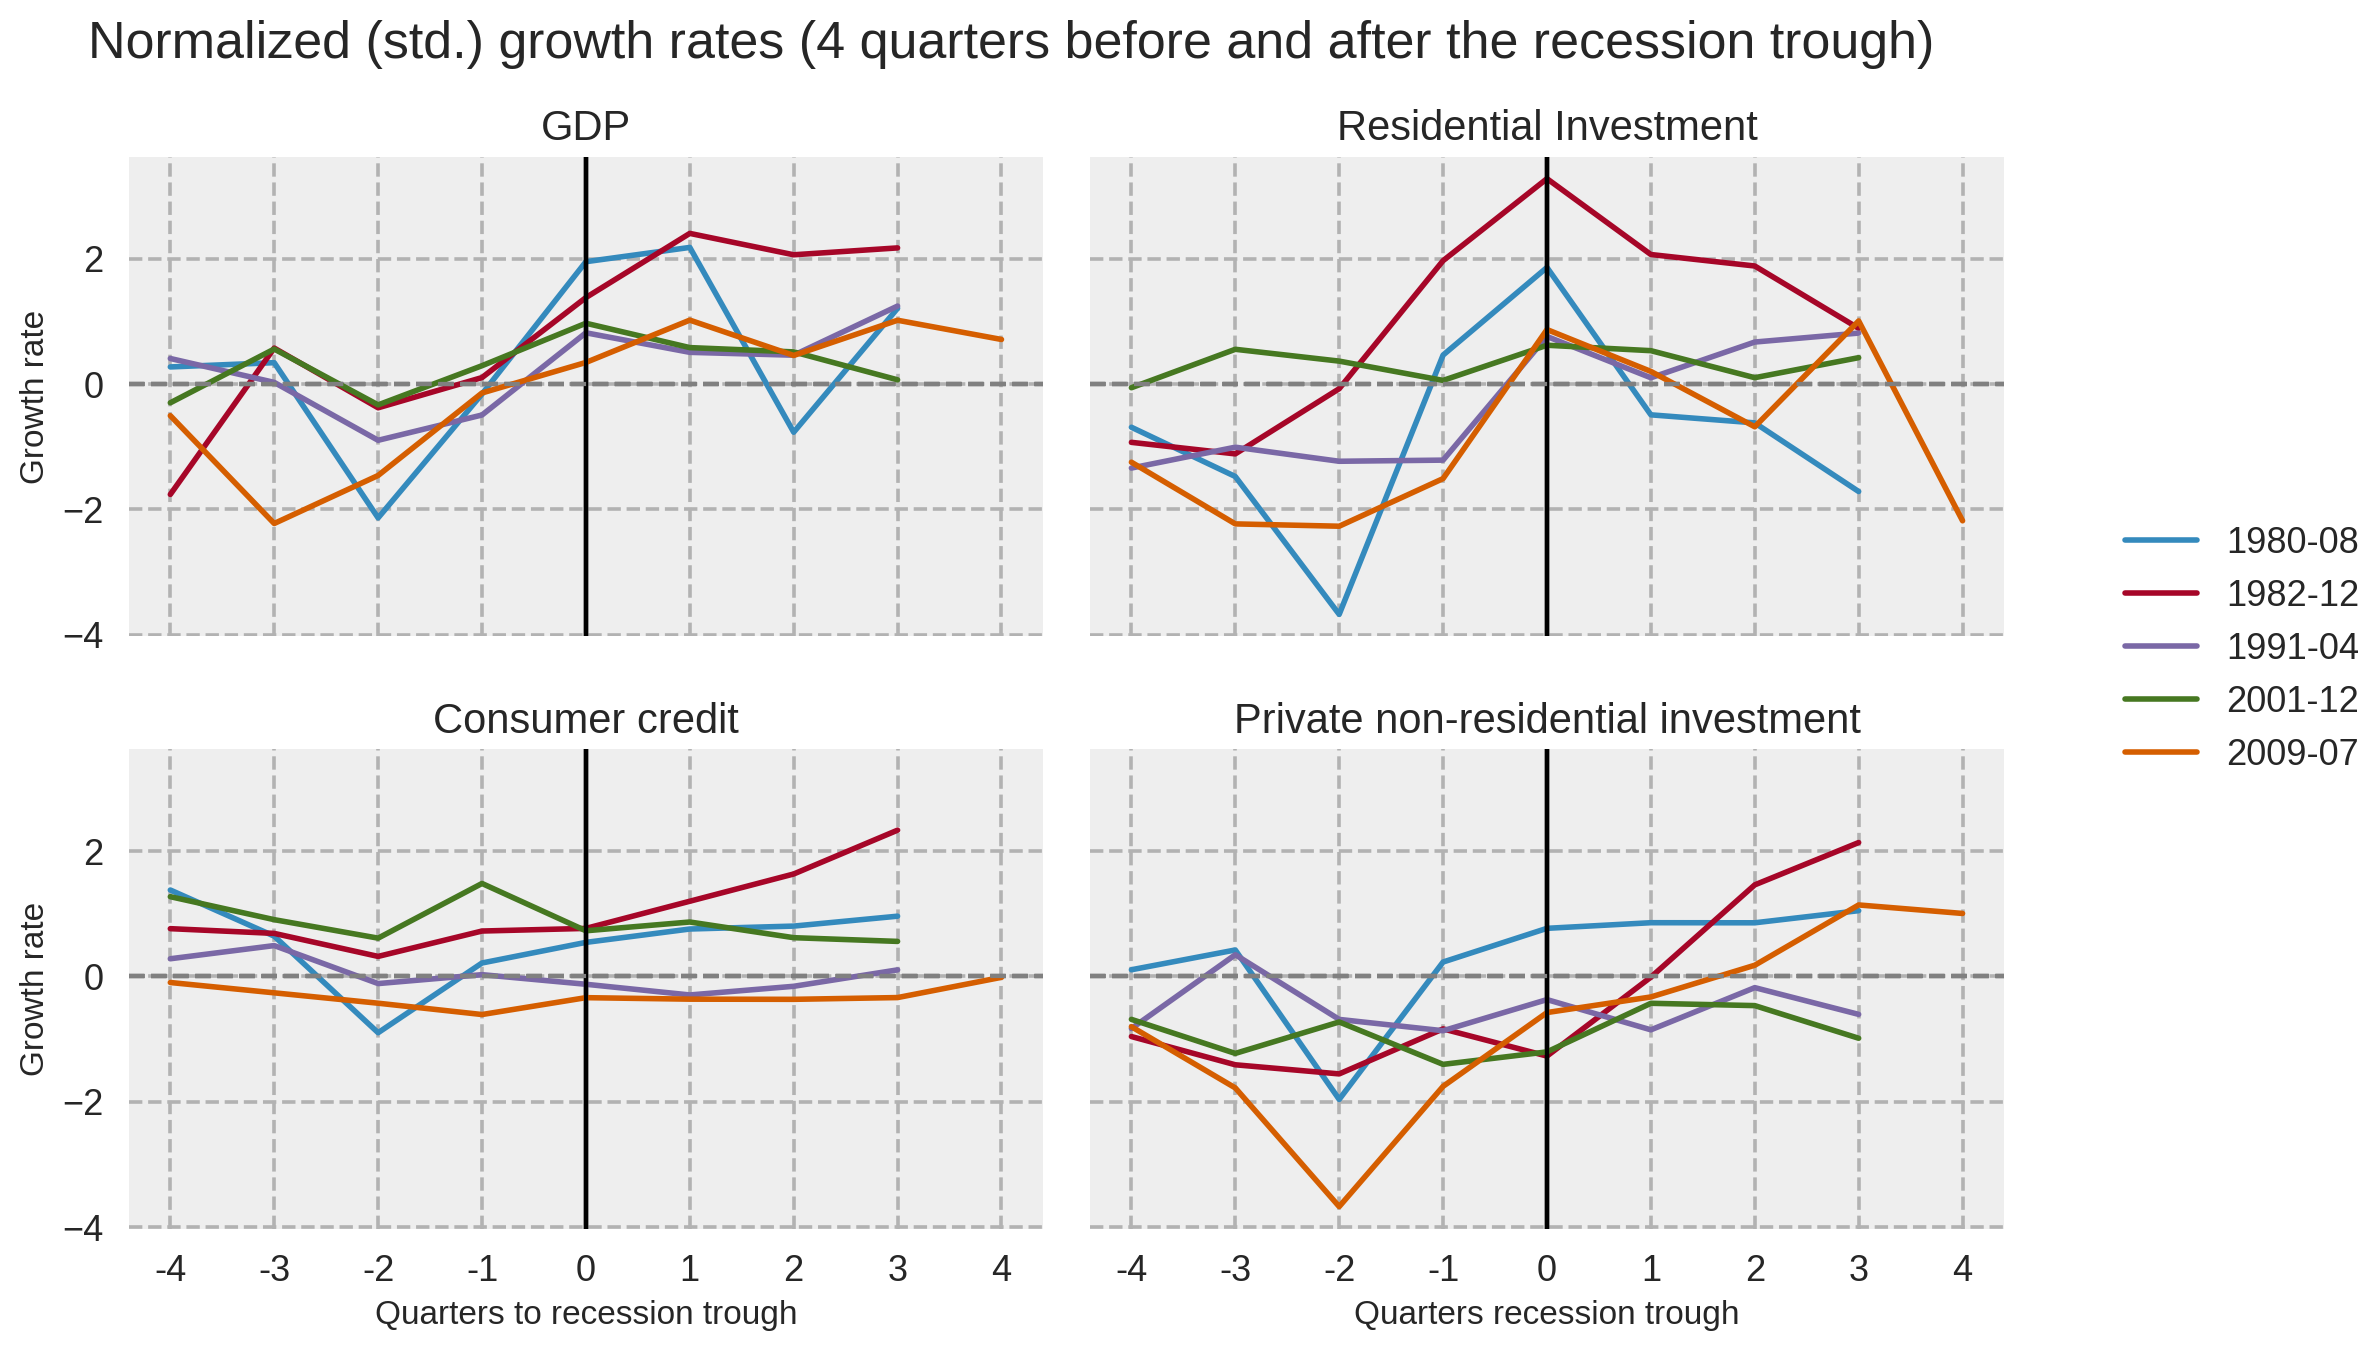

In [0]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)

for i in range(len(centeredT)):
  ax[0,0].plot(df['GDP'].pct_change().apply(lambda x: x/np.std(df['GDP'].pct_change()))[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  handles, labels = ax[0,0].get_legend_handles_labels()
  ax[0,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,0].set_title('GDP', fontsize=15)
  ax[0,0].set_ylabel('Growth rate', fontsize=12)
  ax[0,0].axhline(y=0, color='gray', ls='--', lw=1.5)

for i in range(len(centeredT)):
  ax[0,1].plot(df['Residential Investment'].pct_change().apply(lambda x: x/np.std(df['Residential Investment'].pct_change()))[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  ax[0,1].set_title('Residential Investment', fontsize=15)
  ax[0,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[0,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  


for i in range(len(centeredT)):
  ax[1,0].plot(df['Consumer credit'].pct_change().apply(lambda x: x/np.std(df['Consumer credit'].pct_change()))[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  ax[1,0].set_title('Consumer credit', fontsize=15)
  ax[1,0].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,0].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,0].set_xlabel('Quarters to recession trough', fontsize=12)
  ax[1,0].set_ylabel('Private non-residential investment', fontsize=15)
  ax[1,0].set_ylabel('Growth rate', fontsize=12)

for i in range(len(centeredT)):
  ax[1,1].plot(df['Private non-residential investment'].pct_change().apply(lambda x: x/np.std(df['Private non-residential investment'].pct_change()))[centeredT[i][0]:centeredT[i][2]].values, label=centeredT[i][1], lw=2, ls='-')
  ax[1,1].set_title('Private non-residential investment', fontsize=15)
  ax[1,1].axvline(x=4, color='k', ls='-', lw=1.5)
  ax[1,1].axhline(y=0, color='gray', ls='--', lw=1.5)
  ax[1,1].set_xlabel('Quarters recession trough', fontsize=12)
  
  

plt.xticks(x, xaxis)
sns.despine()
fig.legend(handles, labels, bbox_to_anchor=(1.15, 0.6))
fig.suptitle('Normalized (std.) growth rates (4 quarters before and after the recession trough)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.set_dpi(100)
plt.show()

# Contributions

In [0]:
contributions = df[['GDP', 'Autonomous']].pct_change()
contributions['RES'] = (df['Residential Investment']/df['GDP'])*df['Residential Investment'].pct_change()
contributions['CC'] = (df['Consumer credit']/df['GDP'])*df['Consumer credit'].pct_change()
contributions['G'] = (df['Government spending']/df['GDP'])*df['Government spending'].pct_change()
contributions['X'] = (df['Exports']/df['GDP'])*df['Exports'].pct_change()
contributions['Total Z'] = contributions[['RES', 'CC', 'G', 'X']].sum(axis=1)
contributions['SM'] = df['SSM'].pct_change()
contributions['s'] = df['s'].pct_change()*df['s']/df['SSM']
contributions['m'] = df['m'].pct_change()*df['m']/df['SSM']
contributions['h'] = df['h'].pct_change()*df['h']/df['SSM']
contributions['Total SSM'] = contributions[['s', 'm', 'h']].sum(axis=1)
contributions.index = contributions.index.year
contributions.tail()

,GDP,Autonomous,RES,CC,G,X,Total Z,SM,s,m,h,Total SSM
DATE,,,,,,,,,,,,
2016,0.001448,0.008444,0.001083,0.003656,0.000785,-0.000830,0.004694,0.001589,0.000545,-1.539084e-03,-5.427603e-04,-0.001537
2016,0.005548,0.007290,0.000205,0.003370,-0.000410,0.000871,0.004036,-0.000098,0.000029,1.431823e-07,1.590980e-17,0.000029
2016,0.006879,0.011381,0.000255,0.003856,0.000215,0.001984,0.006310,-0.008433,0.001424,1.163805e-03,0.000000e+00,0.002588
2016,0.004367,0.005956,0.001197,0.003327,0.000074,-0.001228,0.003371,-0.009161,0.001049,1.253779e-03,-5.524593e-04,0.001751
2017,0.003075,0.010632,0.001149,0.002804,-0.000269,0.002283,0.005967,-0.006138,0.001185,1.903498e-03,1.137529e-03,0.004226


# Peak based plot

In [0]:
peakbase = [[(peak[i+5] - pd.to_timedelta(3, unit='M')).strftime('%Y-%m'),centered[i][1] , centeredT[i][1]] for i in range(len(centered))]
peakbase

[['1979-10', '1980-01', '1980-08'],
 ['1981-03', '1981-07', '1982-12'],
 ['1990-03', '1990-07', '1991-04'],
 ['2000-11', '2001-03', '2001-12'],
 ['2007-08', '2007-12', '2009-07']]

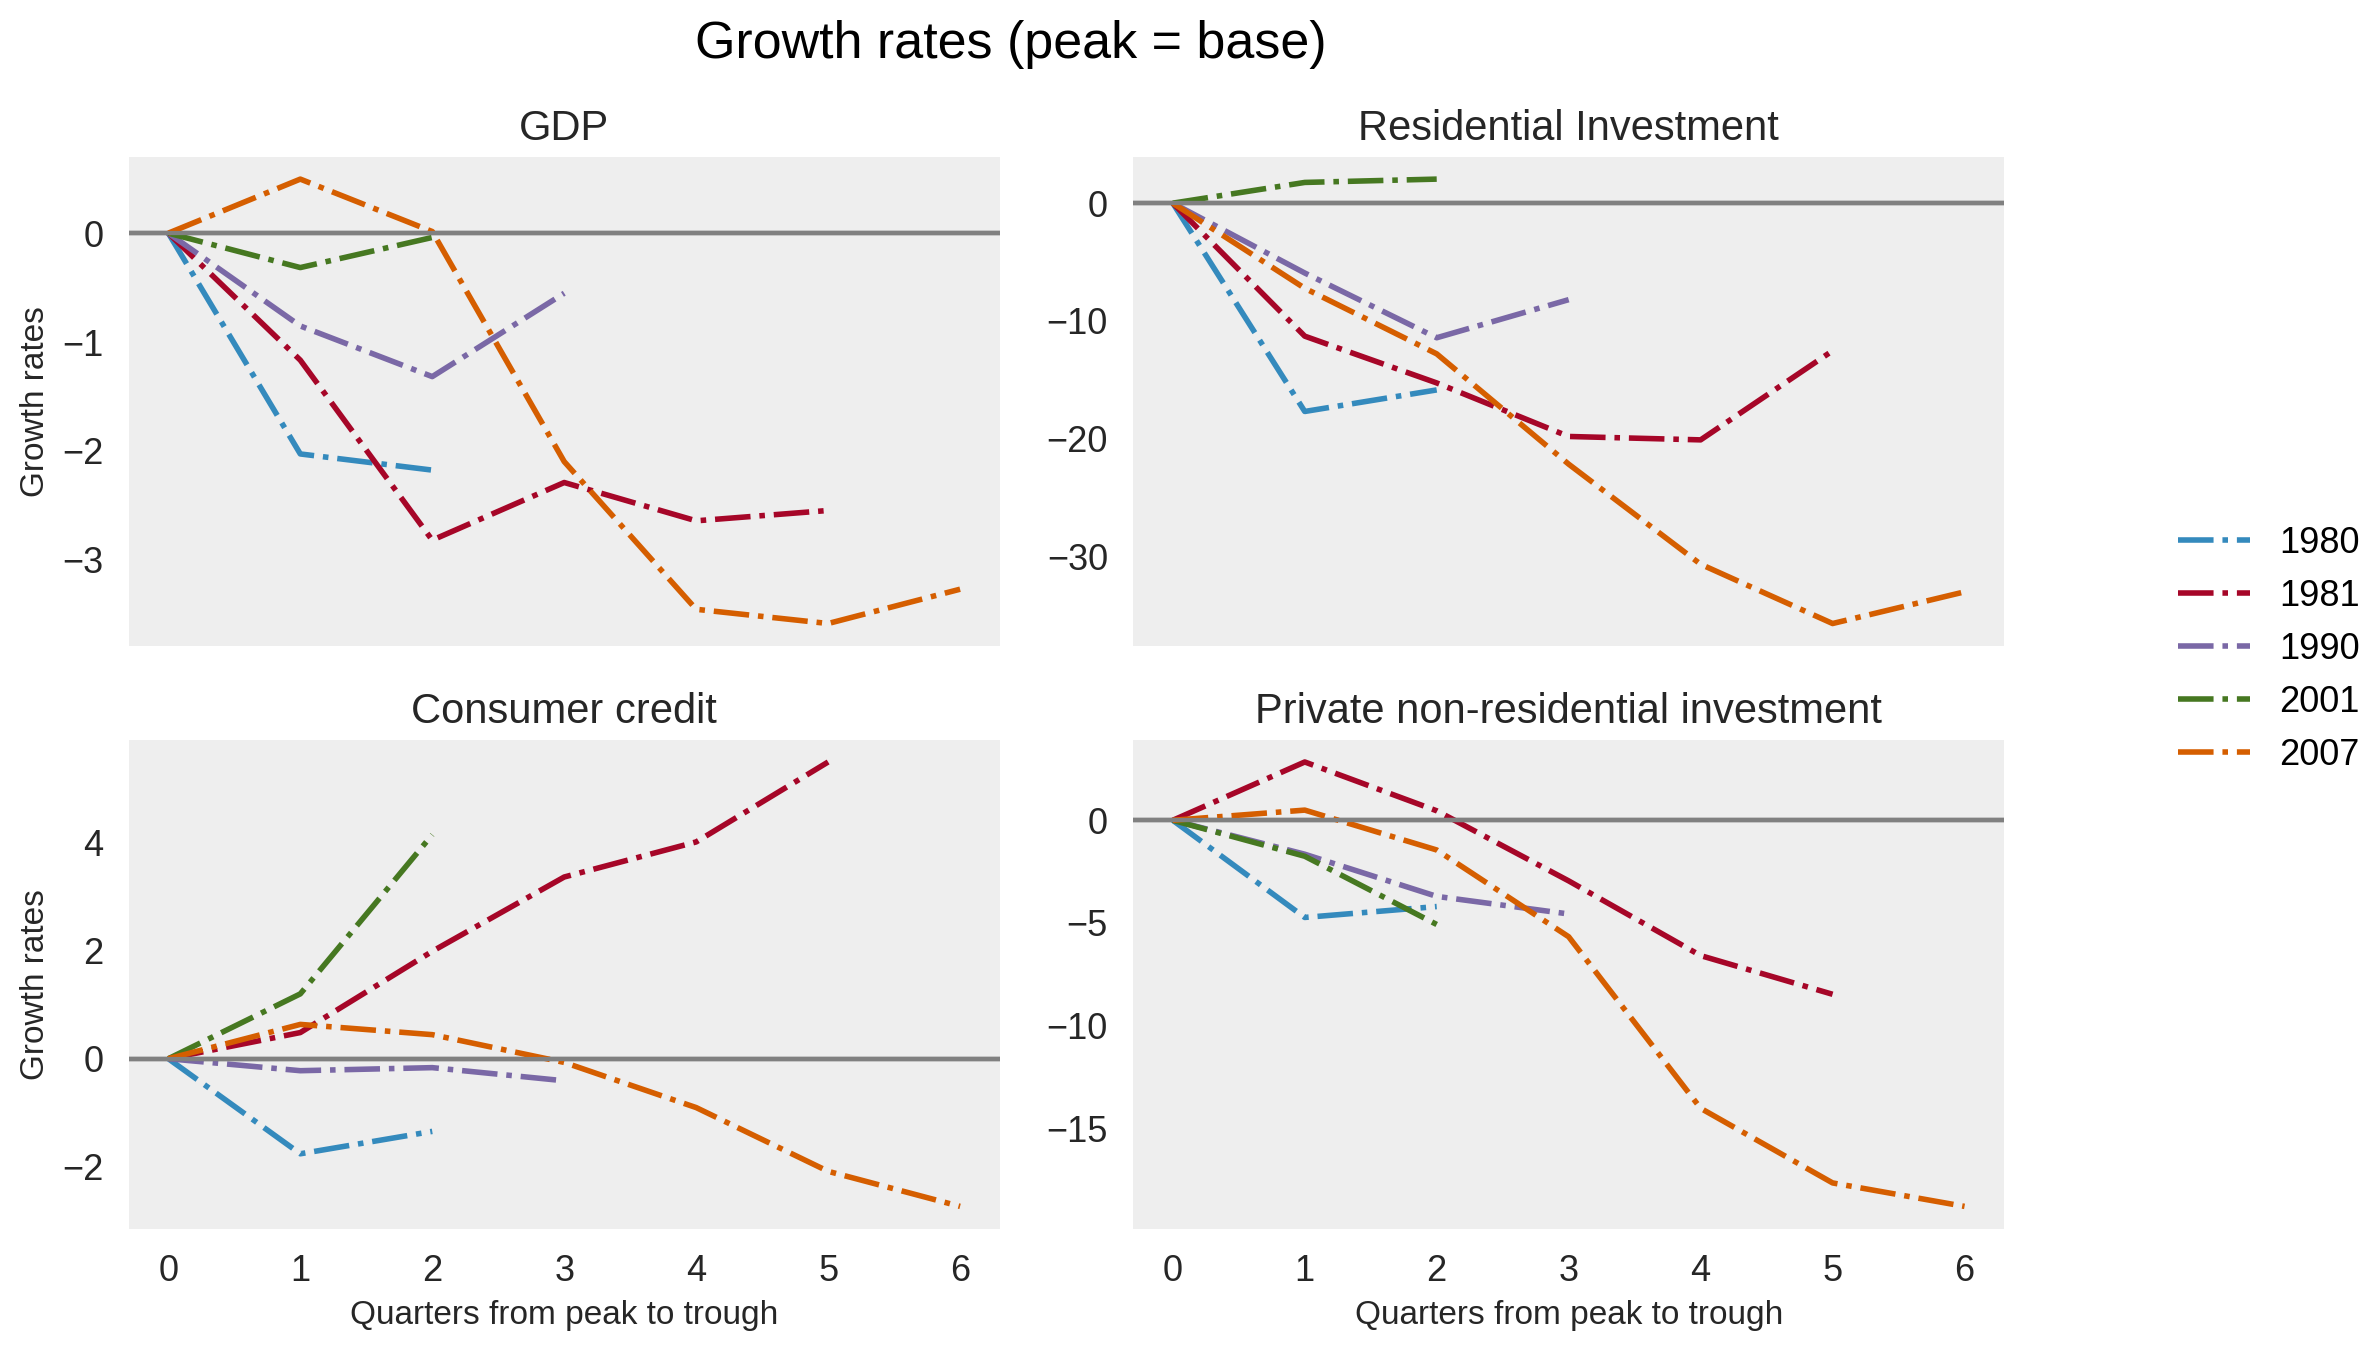

In [0]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=False)
plt.style.use('grayscale')


for i in range(len(peakbase)):
  ax[0,0].plot(df['GDP'][peakbase[i][1]:peakbase[i][2]].divide(df['GDP'][peakbase[i][1]:peakbase[i][2]][0]).apply(lambda x: x*100 - 100).values, label=peakbase[i][1][:4], lw=2, ls='-.')
  handles, labels = ax[0,0].get_legend_handles_labels()
  ax[0,0].set_title('GDP', fontsize=15)
  ax[0,0].set_ylabel('Growth rates', fontsize=12)
  ax[0,0].axhline(y=0, color='gray', ls='-', lw=1.5)
  ax[0,0].grid(False)

for i in range(len(peakbase)):
  ax[0,1].plot(df['Residential Investment'][peakbase[i][1]:peakbase[i][2]].divide(df['Residential Investment'][peakbase[i][1]:peakbase[i][2]][0]).apply(lambda x: x*100 - 100).values, label=peakbase[i][1][:4], lw=2, ls='-.')
  handles, labels = ax[0,0].get_legend_handles_labels()
  ax[0,1].set_title('Residential Investment', fontsize=15)
  ax[0,1].axhline(y=0, color='gray', ls='-', lw=1.5)
  ax[0,1].grid(False)
  
  
for i in range(len(peakbase)):
  ax[1,0].plot(df['Consumer credit'][peakbase[i][1]:peakbase[i][2]].divide(df['Consumer credit'][peakbase[i][1]:peakbase[i][2]][0]).apply(lambda x: x*100 - 100).values, label=peakbase[i][1][:4], lw=2, ls='-.')
  ax[1,0].set_title('Consumer credit', fontsize=15)
  ax[1,0].set_ylabel('Growth rates', fontsize=12)
  ax[1,0].set_xlabel('Quarters from peak to trough', fontsize=12)
  ax[1,0].axhline(y=0, color='gray', ls='-', lw=1.5)
  ax[1,0].grid(False)

for i in range(len(peakbase)):
  ax[1,1].plot(df['Private non-residential investment'][peakbase[i][1]:peakbase[i][2]].divide(df['Private non-residential investment'][peakbase[i][1]:peakbase[i][2]][0]).apply(lambda x: x*100 - 100).values, label=peakbase[i][1][:4], lw=2, ls='-.')
  ax[1,1].set_title('Private non-residential investment', fontsize=15)
  ax[1,1].set_xlabel('Quarters from peak to trough', fontsize=12)
  ax[1,1].axhline(y=0, color='gray', ls='-', lw=1.5)
  ax[1,1].grid(False)

sns.despine(left=False, bottom=False)
fig.legend(handles, labels, bbox_to_anchor=(1.15, 0.6))
fig.suptitle('Growth rates (peak = base)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.set_dpi(100)
fig.set_facecolor('white')
plt.show()

# Finishing

In [0]:
print('Total running time: ', datetime.datetime.now() - t1)

Total running time:  0:00:26.381965
